In [ ]:
# Load dataset
import pandas as pd
import numpy as np


import statsmodels.api as sm
from scipy.stats import shapiro

from dateutil import parser
from dateutil.parser import ParserError
from datetime import datetime

import matplotlib.pyplot as plt
#from matplotlib import rcParams

from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [ ]:
data = pd.read_csv('Battery_input_features_updated.csv')
data_original = data.copy()
df = data.copy()


Convert battery measuremnet time from datetime into integer. This will be used in Pre-Optimisation datasets and models.

In [ ]:
def date_standardizer(date):
#date = '2008-04-02 13:08:17'
  ideal_format = "%Y%m%d%H%M%S"
  return int(parser.parse(date).strftime(ideal_format))
data_original['Battery_measurement_time'] = data_original['Battery_measurement_time'].apply(date_standardizer)

#EDA

In [ ]:
data.head()

,Unnamed: 0,Battery_measurement_time,Battery name,Cycle,Charge_time_measured,Charge_min_Voltage,Charge_max_Voltage,Charge_min_Current_measured,Charge_max_Current_measured,Charge_Temp_measured,Discharge_time_measured,Discharge_min_Voltage_measured,Discharge_max_Voltage_measured,Discharge_min_Current_measured,Discharge_max_Current_measured,Discharge_Temp_measured,Capacity,SOH
0,0,2008-04-02 13:08:17,B0005,0,7597.875,3.479394,4.209949,-4.030268,1.514393,25.324079,3690.234,2.612467,4.191492,-2.018015,0.000729,32.572328,1.856487,100.000000
1,1,2008-04-02 16:37:51,B0005,1,10516.000,3.001951,4.213016,-3.361983,1.515178,26.635623,3672.344,2.587209,4.189773,-2.016821,0.002927,32.725235,1.846327,99.452721
2,2,2008-04-02 20:55:40,B0005,2,10484.547,3.035879,4.212788,-3.384408,1.516894,26.778176,3651.641,2.651917,4.188187,-2.016574,0.001484,32.642862,1.835349,98.861386
3,3,2008-04-03 01:12:38,B0005,3,10397.890,3.066145,4.212924,-3.412263,1.517503,26.703204,3631.563,2.592948,4.188461,-2.015936,0.001547,32.514876,1.835263,98.856718
4,4,2008-04-03 05:27:49,B0005,4,10495.203,3.063766,4.212874,-3.403625,1.516949,26.617004,3629.172,2.547420,4.188299,-2.017426,0.001701,32.382349,1.834646,98.823482


In [ ]:
data.columns

Index(['Unnamed: 0', 'Battery_measurement_time', 'Battery name', 'Cycle',
       'Charge_time_measured', 'Charge_min_Voltage', 'Charge_max_Voltage',
       'Charge_min_Current_measured', 'Charge_max_Current_measured',
       'Charge_Temp_measured', 'Discharge_time_measured',
       'Discharge_min_Voltage_measured', 'Discharge_max_Voltage_measured',
       'Discharge_min_Current_measured', 'Discharge_max_Current_measured',
       'Discharge_Temp_measured', 'Capacity', 'SOH'],
      dtype='object')

Capacity would be dropped because it's assumed it won't be tracked by the stakeholder (when model is deployed).

Unnamed:0 isn't a feature; it was created during the conversion from a dictionary to a DataFrame (in the data cleaning process).

Battery_measurement_time isn't a predictive feature and will be removed.

In [ ]:
df = df.drop(columns=['Unnamed: 0', 'Battery_measurement_time','Capacity'], errors='ignore')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2486 entries, 0 to 2485
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Battery name                    2486 non-null   object 
 1   Cycle                           2486 non-null   int64  
 2   Charge_time_measured            2486 non-null   float64
 3   Charge_min_Voltage              2475 non-null   float64
 4   Charge_max_Voltage              2475 non-null   float64
 5   Charge_min_Current_measured     2475 non-null   float64
 6   Charge_max_Current_measured     2475 non-null   float64
 7   Charge_Temp_measured            2475 non-null   float64
 8   Discharge_time_measured         2486 non-null   float64
 9   Discharge_min_Voltage_measured  2486 non-null   float64
 10  Discharge_max_Voltage_measured  2486 non-null   float64
 11  Discharge_min_Current_measured  2486 non-null   float64
 12  Discharge_max_Current_measured  24

In [ ]:
df = df.dropna()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2475 entries, 0 to 2485
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Battery name                    2475 non-null   object 
 1   Cycle                           2475 non-null   int64  
 2   Charge_time_measured            2475 non-null   float64
 3   Charge_min_Voltage              2475 non-null   float64
 4   Charge_max_Voltage              2475 non-null   float64
 5   Charge_min_Current_measured     2475 non-null   float64
 6   Charge_max_Current_measured     2475 non-null   float64
 7   Charge_Temp_measured            2475 non-null   float64
 8   Discharge_time_measured         2475 non-null   float64
 9   Discharge_min_Voltage_measured  2475 non-null   float64
 10  Discharge_max_Voltage_measured  2475 non-null   float64
 11  Discharge_min_Current_measured  2475 non-null   float64
 12  Discharge_max_Current_measured  2475 no

Derive new voltage drop feature

In [ ]:
df['Voltage_drop'] = df['Discharge_max_Voltage_measured'] - df['Discharge_min_Voltage_measured']

Get statistical summary of data

In [ ]:
df.describe()

,Cycle,Charge_time_measured,Charge_min_Voltage,Charge_max_Voltage,Charge_min_Current_measured,Charge_max_Current_measured,Charge_Temp_measured,Discharge_time_measured,Discharge_min_Voltage_measured,Discharge_max_Voltage_measured,Discharge_min_Current_measured,Discharge_max_Current_measured,Discharge_Temp_measured,SOH,Voltage_drop
count,2475.000000,2475.000000,2475.000000,2475.000000,2475.000000,2475.000000,2475.000000,2475.000000,2475.000000,2475.000000,2475.000000,2475.000000,2475.000000,2475.000000,2475.000000
mean,59.960808,10483.243651,3.374975,4.217803,-1.768155,1.492213,19.960872,3235.766107,2.353216,4.185992,-2.449667,0.001221,26.288841,112.987427,1.832776
std,48.038633,916.578473,0.343844,0.119549,1.638943,0.073269,12.210527,1393.222117,0.294999,0.014338,1.122650,0.002456,14.011405,171.432965,0.295826
min,0.000000,1674.484000,2.264128,4.200001,-4.508828,1.084266,5.165115,23.000000,0.986134,3.986547,-4.038796,-0.006740,4.857764,0.000000,0.344081
25%,21.000000,10564.157000,3.173312,4.201782,-3.531512,1.500881,6.362760,2518.547000,2.129436,4.181693,-3.992165,-0.000287,10.574709,78.183369,1.553540
50%,47.000000,10803.203000,3.301409,4.203077,-2.235610,1.512232,25.116393,3031.953000,2.430384,4.186242,-2.014434,0.001129,31.001432,87.573024,1.761807
75%,89.000000,10806.007500,3.678304,4.213176,-0.002260,1.517880,26.047544,3387.375000,2.635397,4.194374,-1.992688,0.002514,34.708238,96.527935,2.052622
max,195.000000,10818.797000,4.157326,8.393141,0.005373,1.536047,46.206803,6574.671000,3.838396,4.222920,-0.996920,0.018424,58.954811,2182.593485,3.203035


Get maximum SOH per battery.

In [ ]:
df[['Battery name', 'SOH']].groupby('Battery name').max(['SOH']).to_excel("Batteries by Maximum SOH.xlsx")
df[['Battery name', 'SOH']].groupby('Battery name').max(['SOH'])

,SOH
Battery name,
B0005,100.000000
B0006,100.000000
B0018,100.000000
B0026,100.180745
B0027,100.000000
B0028,100.005461
B0030,100.000000
B0031,100.000000
B0032,100.000000


Get SOH stats summary

In [ ]:
Stats_Summary = df['SOH'].describe()
Stats_Summary.to_excel("Stats Summary SOH.xlsx")
Stats_Summary

,SOH
count,2475.000000
mean,112.987427
std,171.432965
min,0.000000
25%,78.183369
50%,87.573024
75%,96.527935
max,2182.593485


Box plot of all voltage features

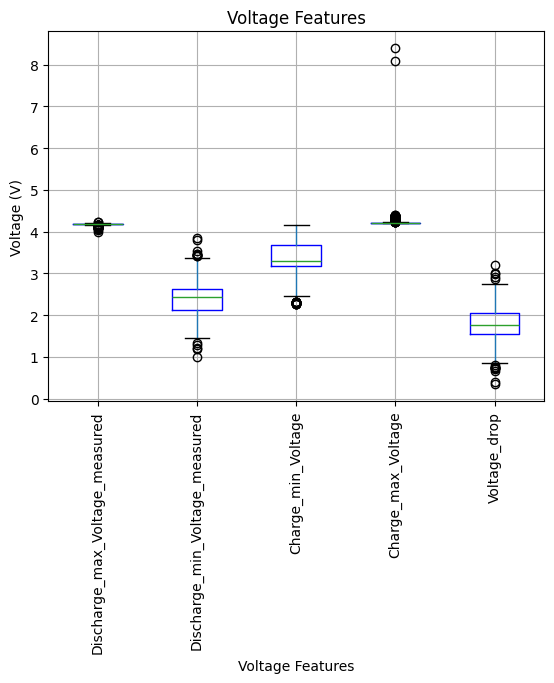

In [ ]:
ax = df.boxplot(column=['Discharge_max_Voltage_measured','Discharge_min_Voltage_measured','Charge_min_Voltage', 'Charge_max_Voltage','Voltage_drop'], boxprops=dict(color="blue"))
plt.xticks(rotation=90)
plt.title('Voltage Features')
plt.xlabel('Voltage Features')
plt.ylabel('Voltage (V)')
plt.show()

Box plot of all current features

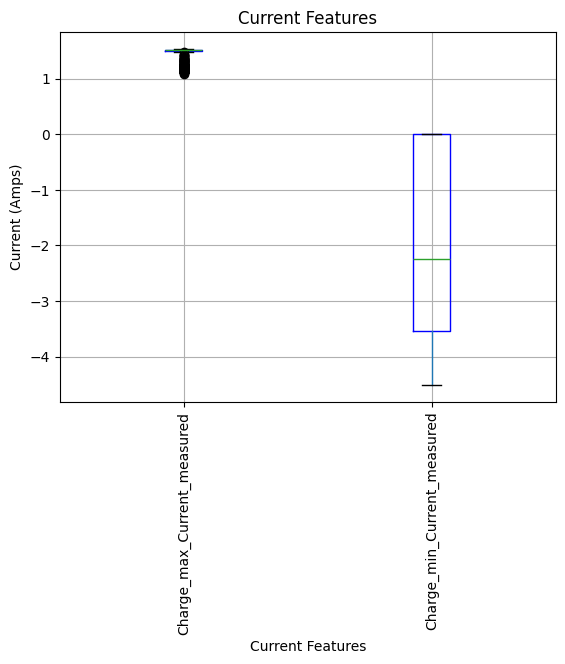

In [ ]:
ax = df.boxplot(column=['Charge_max_Current_measured','Charge_min_Current_measured'], boxprops=dict(color="blue"))
plt.xticks(rotation=90)
plt.title('Current Features')
plt.xlabel('Current Features')
plt.ylabel('Current (Amps)')
plt.show()

Box plot of time features

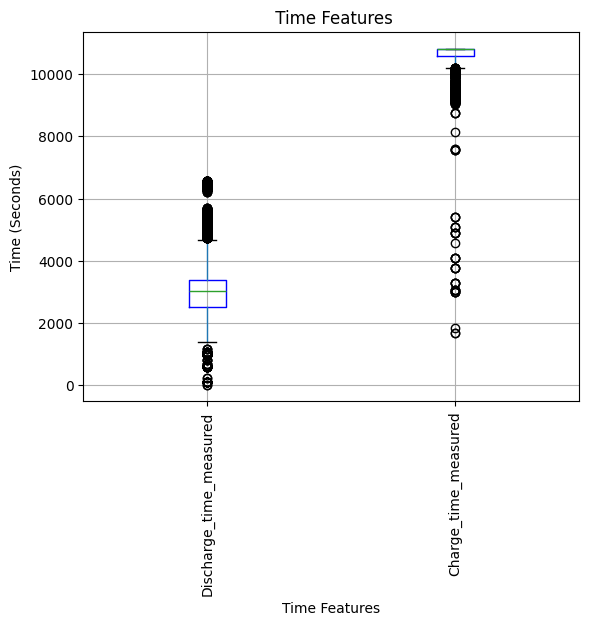

In [ ]:
ax = df.boxplot(column=['Discharge_time_measured','Charge_time_measured'], boxprops=dict(color="blue"))
plt.xticks(rotation=90)
plt.title(' Time Features')
plt.xlabel('Time Features')
plt.ylabel('Time (Seconds)')
plt.show()

Box plot of Temperature features

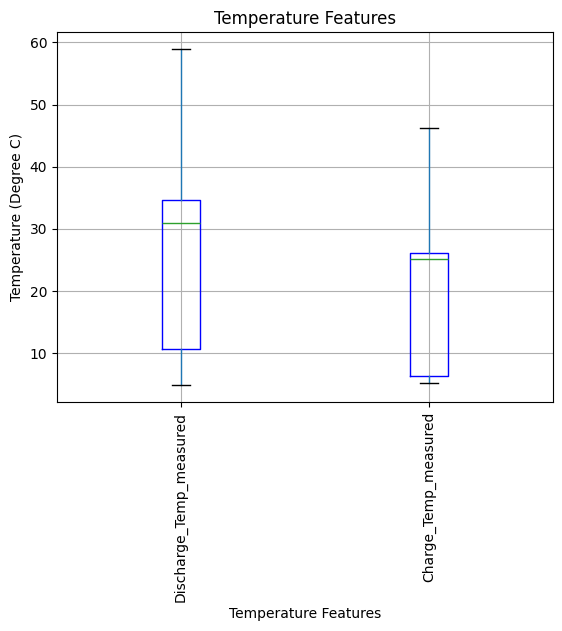

In [ ]:
ax = df.boxplot(column=['Discharge_Temp_measured','Charge_Temp_measured'], boxprops=dict(color="blue"))
plt.xticks(rotation=90)
plt.title('Temperature Features')
plt.xlabel('Temperature Features')
plt.ylabel('Temperature (Degree C)')
plt.show()

Histogram of all columns

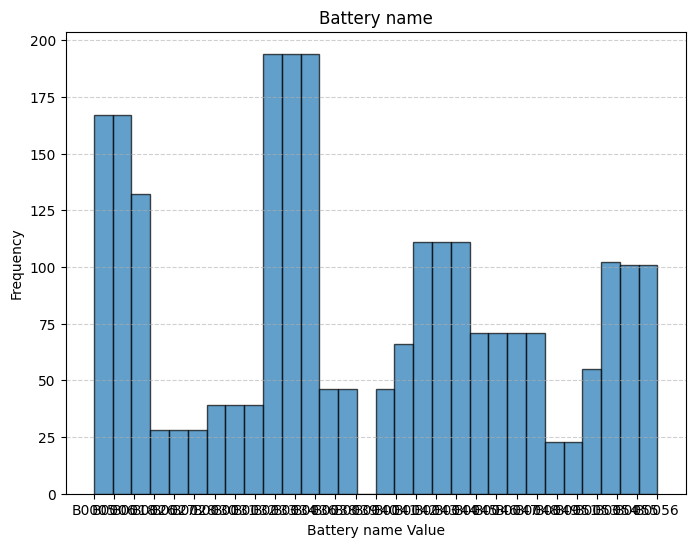

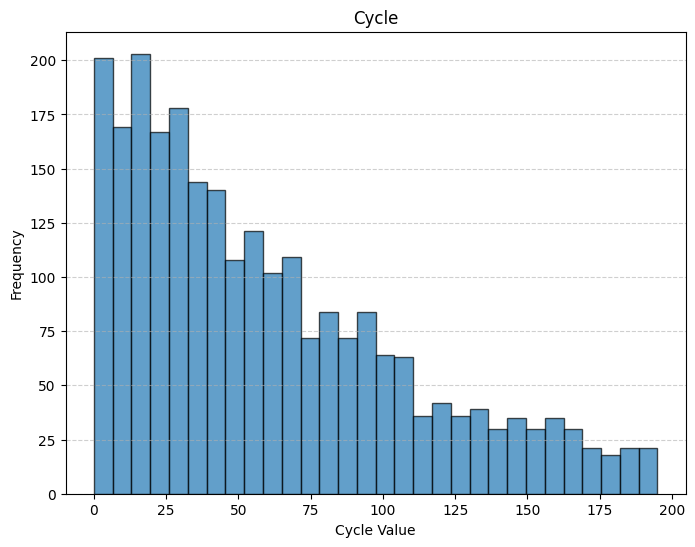

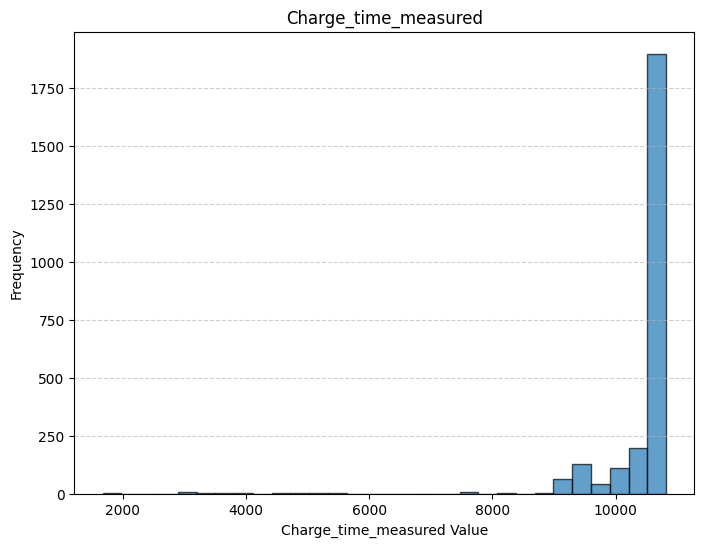

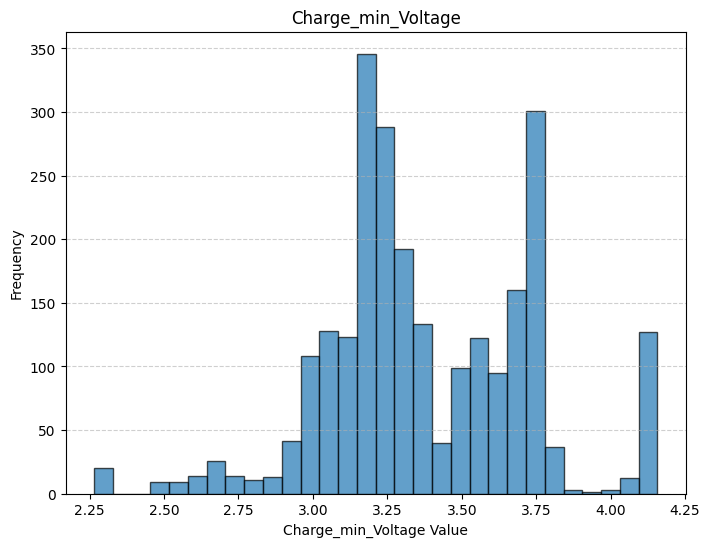

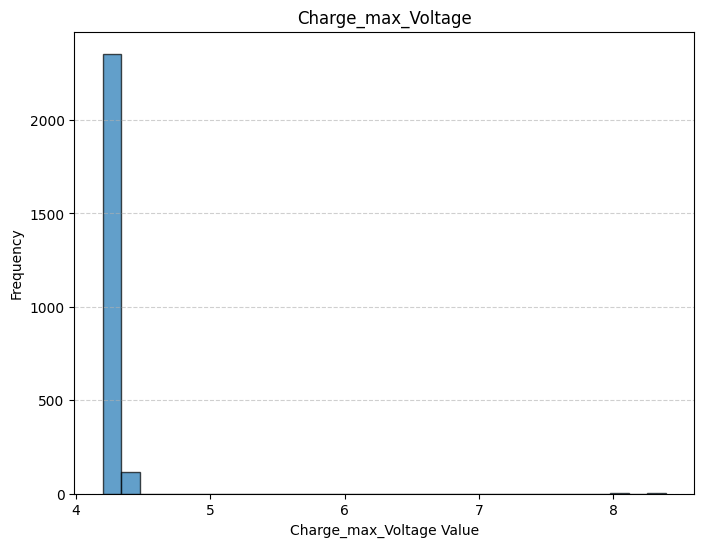

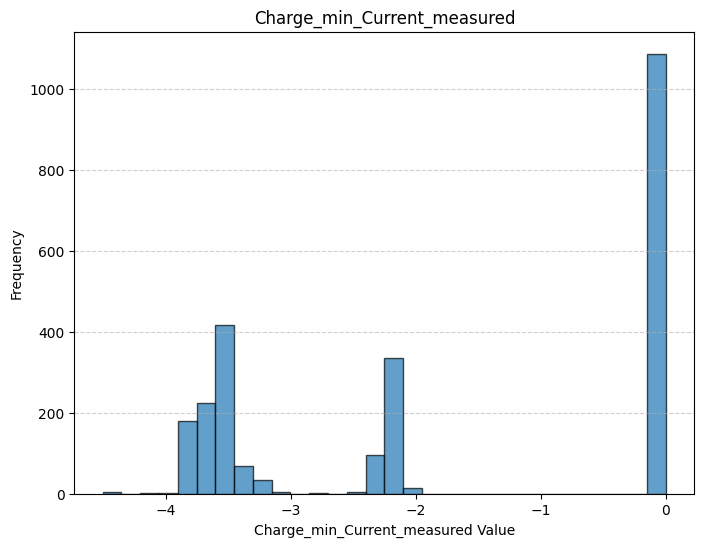

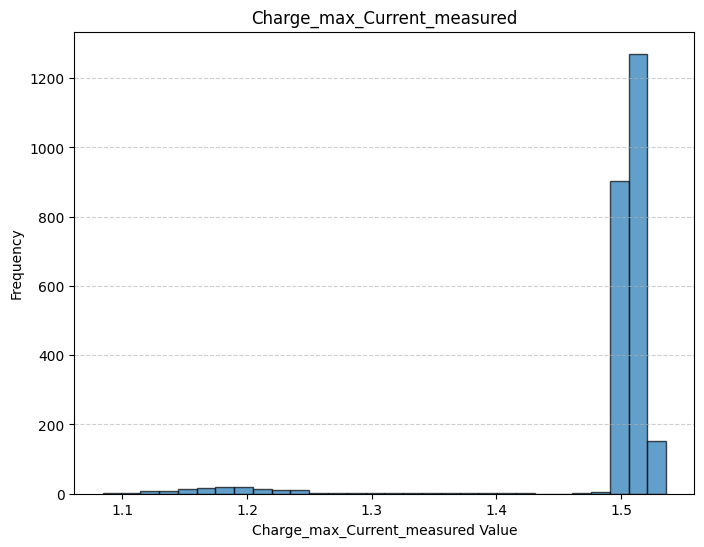

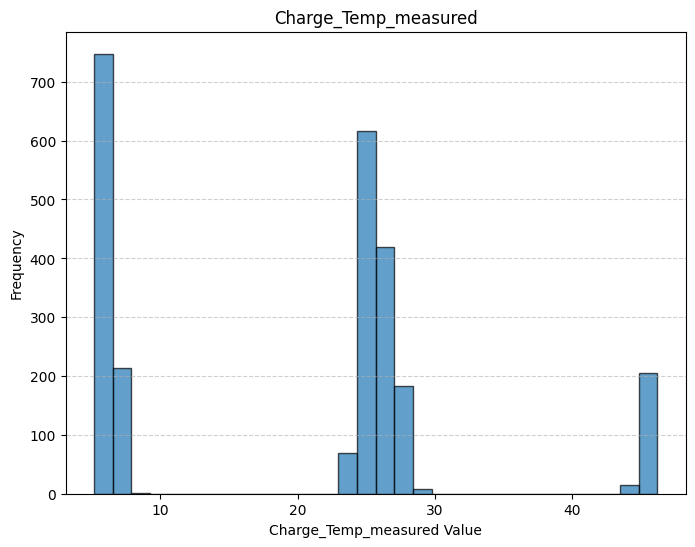

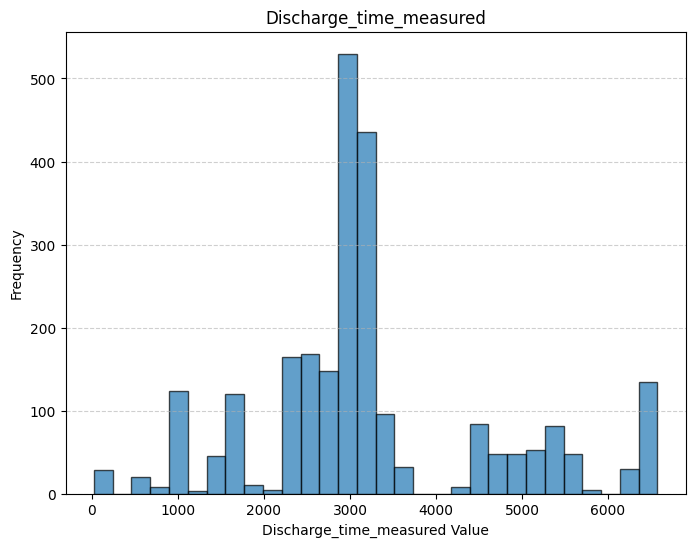

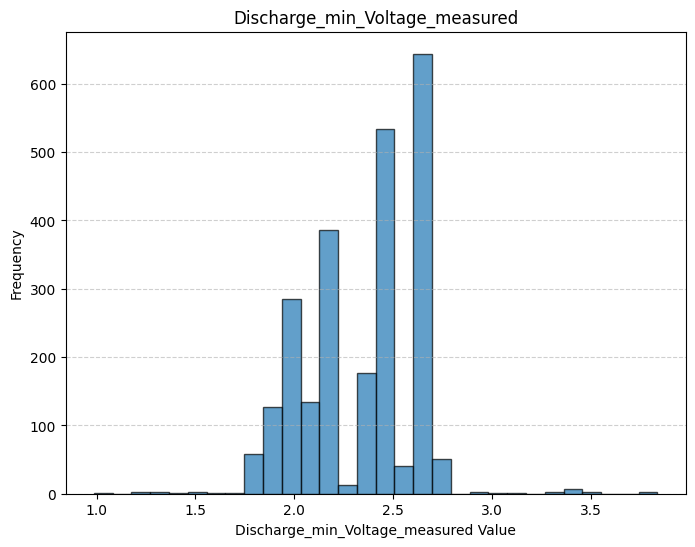

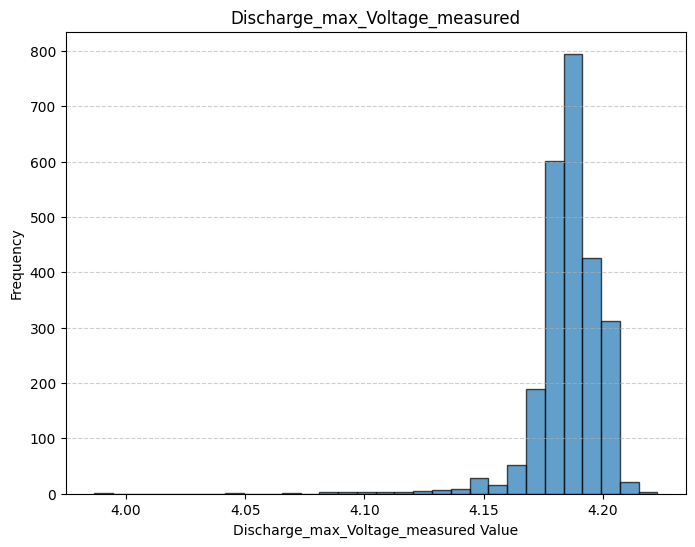

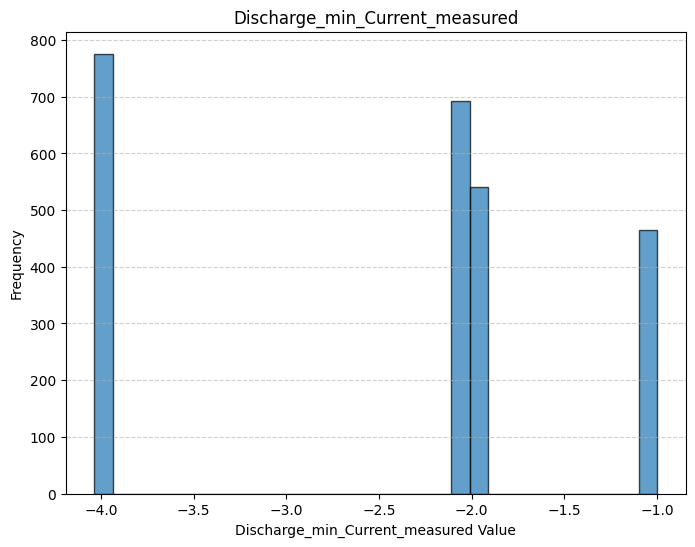

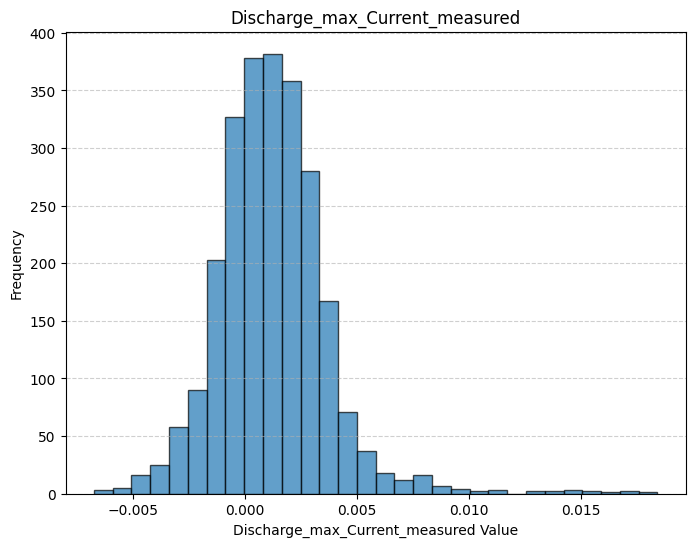

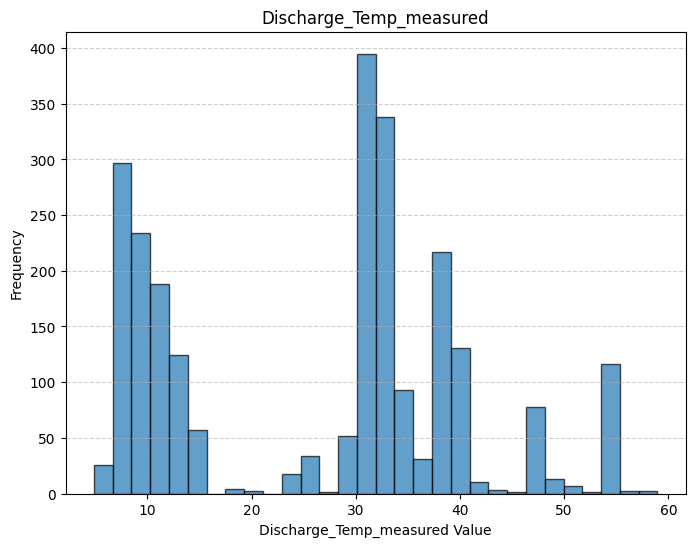

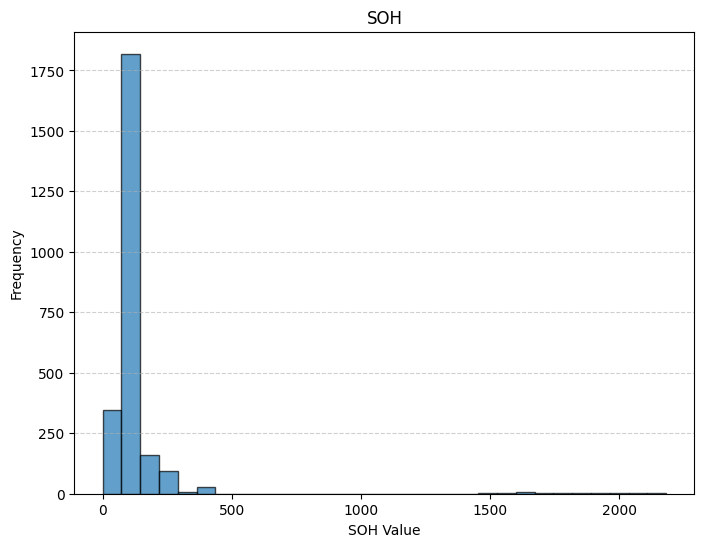

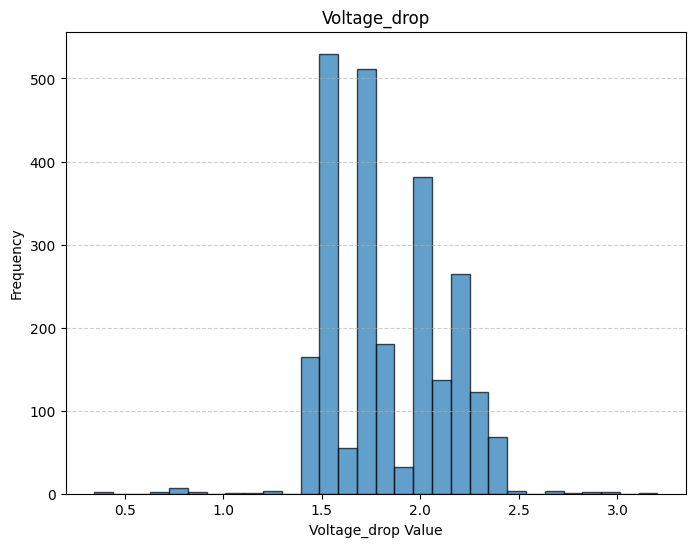

In [ ]:
Columns = df.columns.tolist()
for col in Columns:
  plt.figure(figsize=(8, 6))
  plt.hist(df[col], bins=30, edgecolor='black', alpha=0.7) # 'bins' controls the number of bars
  plt.title(col)
  plt.xlabel(col + ' Value')
  plt.ylabel('Frequency')
  plt.grid(axis='y', linestyle='--', alpha=0.6)
  plt.show()

Histogram of Cycle feature

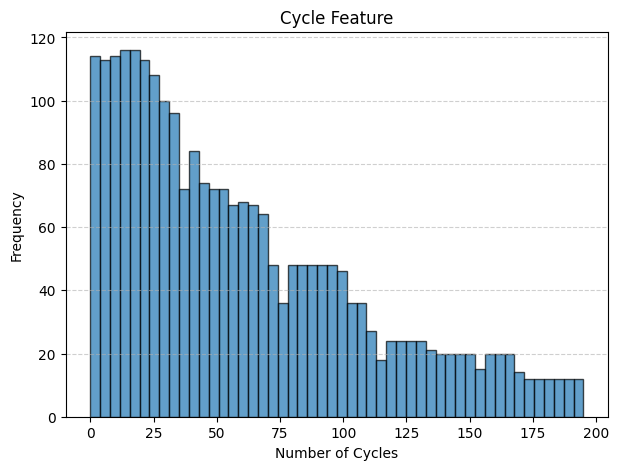

In [ ]:
plt.figure(figsize=(7, 5))
plt.hist(df['Cycle'], bins=50, edgecolor='black', alpha=0.7) # 'bins' controls the number of bars
plt.title('Cycle Feature')
plt.xlabel('Number of Cycles')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

Get each battery by their number of cycles and minimum SOH values

In [ ]:
df[['Battery name', 'Cycle','SOH']].groupby('Battery name').agg(
    {    'Cycle': 'max',
        'SOH': 'min'
    }).to_excel('Battery_name, Cycle and SOH.xlsx')

df[['Battery name', 'Cycle','SOH']].groupby('Battery name').agg(
    {    'Cycle': 'max',
        'SOH': 'min'
    })

,Cycle,SOH
Battery name,,
B0005,168,69.348842
B0006,168,56.689285
B0018,133,72.293702
B0026,29,76.455922
B0027,29,97.081395
B0028,29,95.154212
B0030,38,87.720026
B0031,38,90.967137
B0032,38,86.366024


Review each cycle of battery 'B0045'

In [ ]:
Battery_name = 'B0045'
condition = data_original['Battery name'] == Battery_name
data_original[condition].to_excel(f'{Battery_name}.xlsx')
data_original[condition]

,Unnamed: 0,Battery_measurement_time,Battery name,Cycle,Charge_time_measured,Charge_min_Voltage,Charge_max_Voltage,Charge_min_Current_measured,Charge_max_Current_measured,Charge_Temp_measured,Discharge_time_measured,Discharge_min_Voltage_measured,Discharge_max_Voltage_measured,Discharge_min_Current_measured,Discharge_max_Current_measured,Discharge_Temp_measured,Capacity,SOH
1795,0,20100721172540,B0045,0,10803.313,3.701651,4.212506,0.000471,1.514075,6.398133,5650.265,1.987597,4.166999,-1.008743,0.002694,9.412486,0.927952,100.000000
1796,1,20100721223843,B0045,1,10802.078,3.664882,4.214912,0.000947,1.512024,6.346661,5590.907,1.988538,4.187894,-1.009056,0.004061,9.144413,0.885194,95.392135
1797,2,20100722031453,B0045,2,10807.688,3.676401,4.215772,-0.001604,1.512707,6.184674,5543.610,1.969242,4.188401,-1.007865,0.002063,9.074180,0.858101,92.472530
1798,3,20100722075021,B0045,3,10805.687,3.683324,4.216187,-0.000211,1.513316,6.199398,5499.046,1.983054,4.188304,-1.009239,0.002621,9.063698,0.840935,90.622667
1799,4,20100722122503,B0045,4,10804.078,3.689718,4.216835,-0.002420,1.513104,6.132890,5461.219,1.980465,4.188280,-1.008210,0.001774,9.076577,0.824547,88.856626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861,66,20100816125614,B0045,66,10806.641,3.728048,4.227592,-0.004092,1.512908,6.399343,4663.907,1.975425,4.165487,-1.007761,0.002968,9.495185,0.649581,70.001581
1862,67,20100816175319,B0045,67,10807.969,3.721502,4.228189,-0.005622,1.511483,6.444081,4581.328,1.984307,4.189250,-1.007879,0.000711,9.474914,0.633749,68.295369
1863,68,20100816221302,B0045,68,10809.594,3.720787,4.227652,-0.001250,1.512023,6.422819,4553.031,1.988172,4.189076,-1.011052,0.002907,9.411640,0.629855,67.875797
1864,69,20100817023220,B0045,69,10804.109,3.721940,4.226519,-0.001116,1.512182,6.388268,4486.500,1.980953,4.189729,-1.009350,0.008044,9.476833,0.618306,66.631260


In [ ]:
condition = data_original['SOH'] > 10
data_original[condition].describe()

,Unnamed: 0,Battery_measurement_time,Cycle,Charge_time_measured,Charge_min_Voltage,Charge_max_Voltage,Charge_min_Current_measured,Charge_max_Current_measured,Charge_Temp_measured,Discharge_time_measured,Discharge_min_Voltage_measured,Discharge_max_Voltage_measured,Discharge_min_Current_measured,Discharge_max_Current_measured,Discharge_Temp_measured,Capacity,SOH
count,2330.000000,2.330000e+03,2330.000000,2330.000000,2322.000000,2322.000000,2322.000000,2322.000000,2322.000000,2330.000000,2330.000000,2330.000000,2330.000000,2330.000000,2330.000000,2330.000000,2330.000000
mean,59.899142,2.009328e+13,59.899142,10487.285770,3.337435,4.213173,-1.884306,1.503961,20.839885,3387.228554,2.343131,4.186793,-2.369884,0.001244,27.264671,1.381909,120.355535
std,49.371930,7.773978e+09,49.371930,868.083814,0.314930,0.120644,1.626306,0.040767,12.064781,1296.714959,0.287396,0.019978,1.089515,0.002455,13.792388,0.361952,174.365067
min,0.000000,2.008040e+13,0.000000,1655.547000,2.264128,4.200001,-4.508828,1.153381,5.172409,96.484000,0.986134,3.986547,-4.038796,-0.006740,5.529021,0.044092,29.375311
25%,20.000000,2.009041e+13,20.000000,10543.359000,3.165383,4.201749,-3.550142,1.501294,6.423327,2775.137000,2.107988,4.181952,-3.978973,-0.000231,11.785910,1.188243,79.960840
50%,44.000000,2.009082e+13,44.000000,10803.063000,3.279204,4.202971,-2.236717,1.512577,25.264045,3056.437000,2.425992,4.186421,-2.014122,0.001159,31.260447,1.420803,88.886319
75%,92.750000,2.010073e+13,92.750000,10806.016000,3.605311,4.210067,-0.002294,1.517992,26.179572,3470.672000,2.635922,4.194226,-1.991783,0.002505,37.390797,1.666791,97.174438
max,195.000000,2.010093e+13,195.000000,10818.797000,4.152899,8.393141,0.005373,1.536047,46.206803,6574.671000,2.699983,4.519252,-0.996920,0.018424,58.954811,2.444062,2182.593485


Remove batteries with high SOH values.

In [ ]:
Batteries = ['B0033', 'B0038', 'B0039', 'B0040','B0041']
for b in Batteries:
  condition =df['Battery name'] != b
  df = df[condition]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2077 entries, 0 to 2485
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Battery name                    2077 non-null   object 
 1   Cycle                           2077 non-null   int64  
 2   Charge_time_measured            2077 non-null   float64
 3   Charge_min_Voltage              2077 non-null   float64
 4   Charge_max_Voltage              2077 non-null   float64
 5   Charge_min_Current_measured     2077 non-null   float64
 6   Charge_max_Current_measured     2077 non-null   float64
 7   Charge_Temp_measured            2077 non-null   float64
 8   Discharge_time_measured         2077 non-null   float64
 9   Discharge_min_Voltage_measured  2077 non-null   float64
 10  Discharge_max_Voltage_measured  2077 non-null   float64
 11  Discharge_min_Current_measured  2077 non-null   float64
 12  Discharge_max_Current_measured  2077 no

Get scatter plot better numeric features and SOH

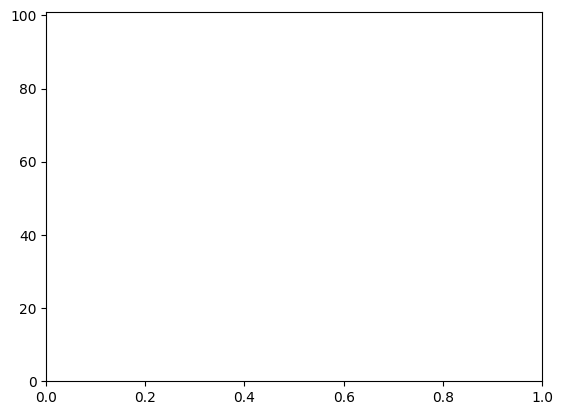

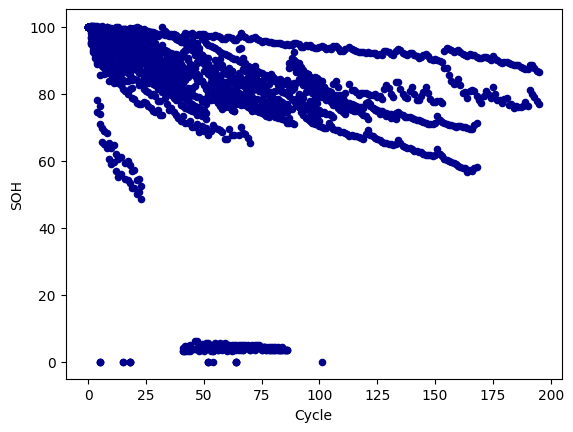

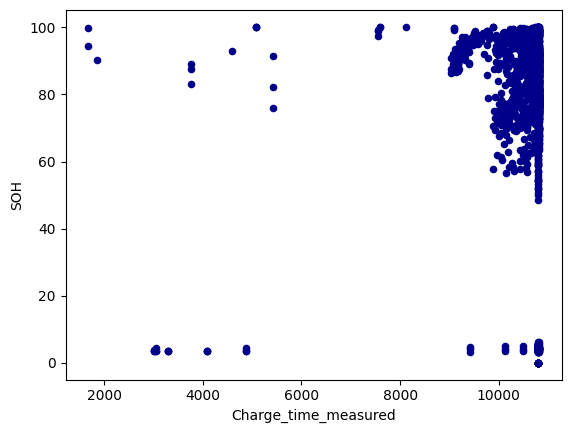

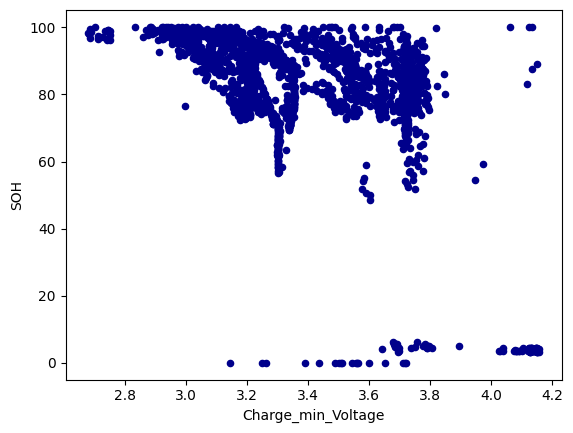

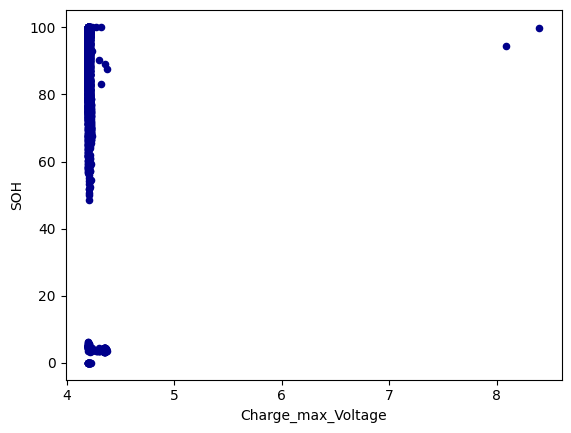

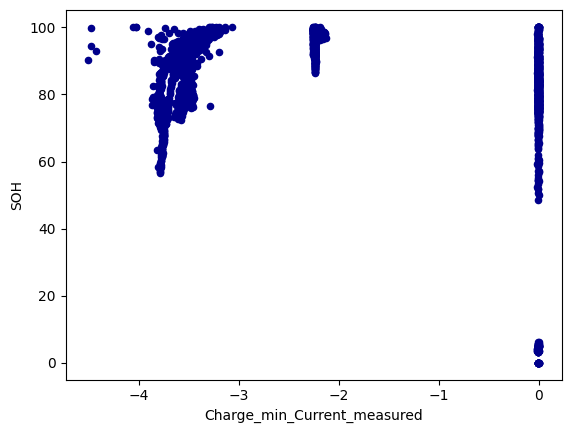

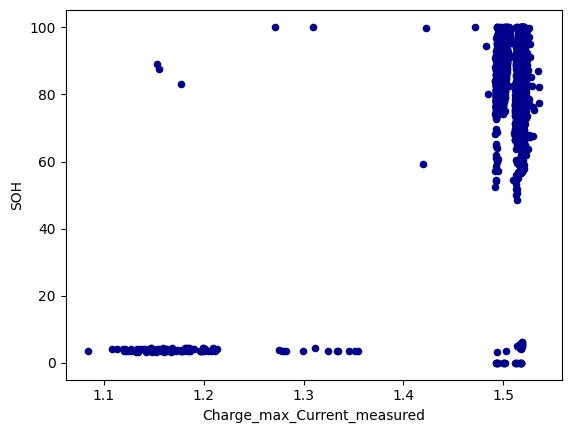

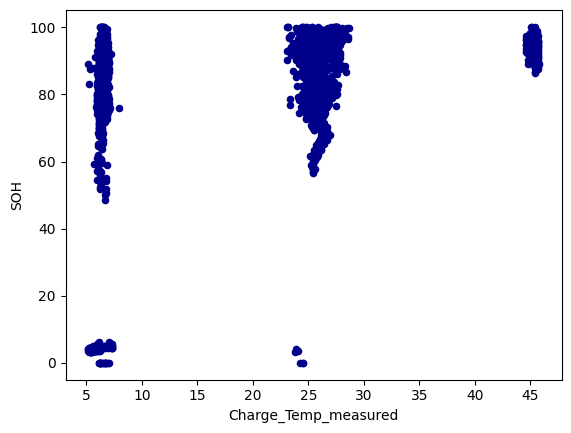

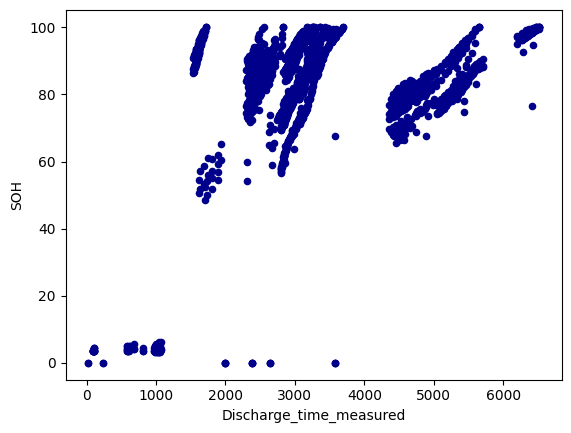

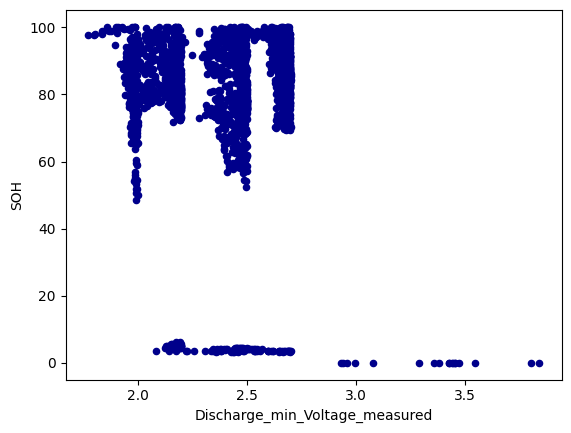

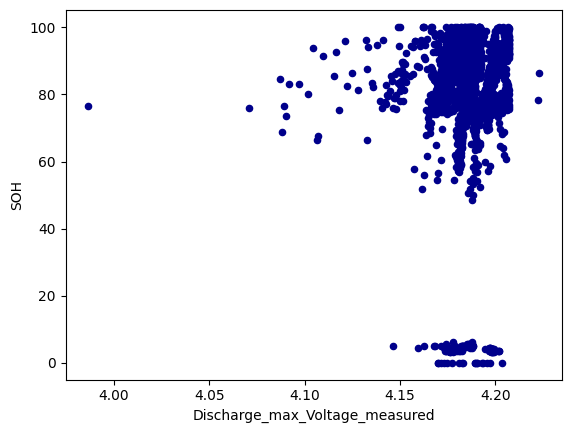

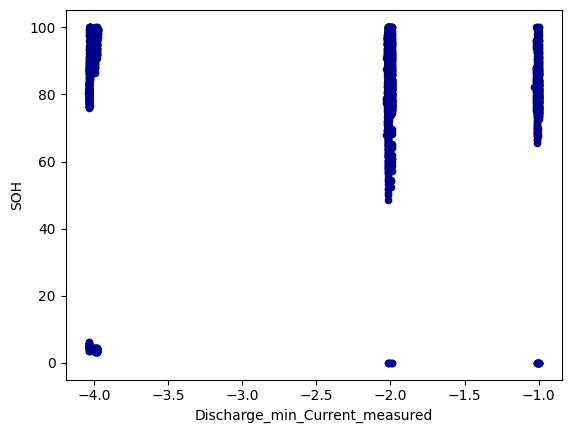

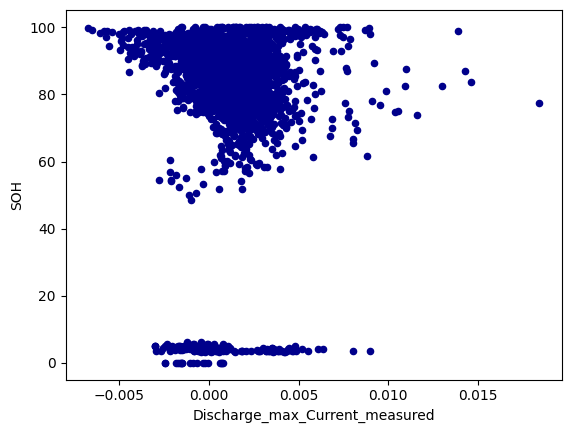

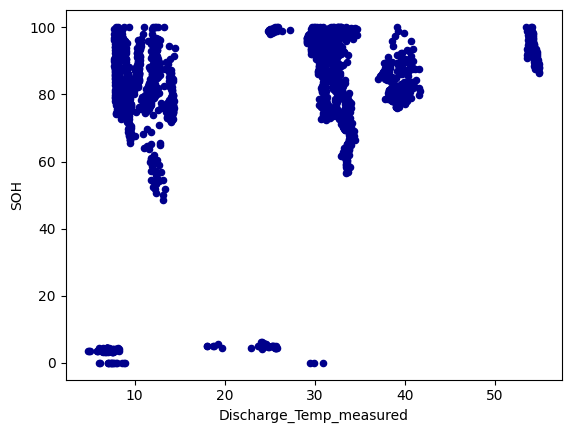

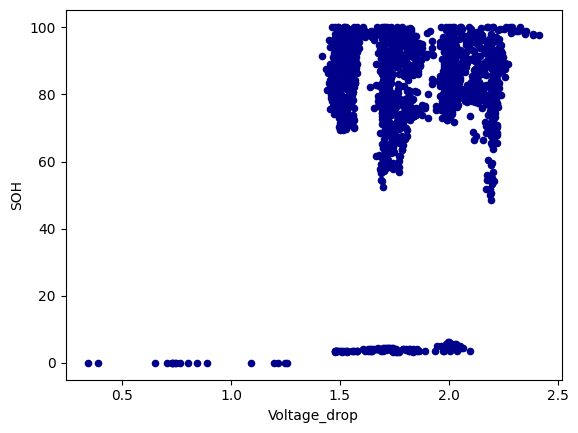

In [ ]:
Columns = df.columns.tolist()
plt.ylim(0, 101)
for col in Columns:#Battery name is not a numeric feature
  if col != 'SOH' and col != 'Battery name':
    df.plot.scatter(x= col,
                  y='SOH',
                  #plt.ylim(0, 101), #scaling 0 to 100
                  c='DarkBlue')


Remove outliers based on box plot lower and upper boundaries.




In [ ]:
Q1 = df['SOH'].quantile(0.25)
Q3 = df['SOH'].quantile(0.75)
IQR = Q3-Q1
Lower_bound = Q1 - (IQR*1.5)
Upper_bound = Q3 + (IQR*1.5)
print(Lower_bound)
print(Upper_bound)

52.708408238950526
116.9899147357999


In [ ]:
condition = (df['SOH'] > Lower_bound) & (df['SOH'] < Upper_bound)
df = df[condition]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1918 entries, 0 to 2485
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Battery name                    1918 non-null   object 
 1   Cycle                           1918 non-null   int64  
 2   Charge_time_measured            1918 non-null   float64
 3   Charge_min_Voltage              1918 non-null   float64
 4   Charge_max_Voltage              1918 non-null   float64
 5   Charge_min_Current_measured     1918 non-null   float64
 6   Charge_max_Current_measured     1918 non-null   float64
 7   Charge_Temp_measured            1918 non-null   float64
 8   Discharge_time_measured         1918 non-null   float64
 9   Discharge_min_Voltage_measured  1918 non-null   float64
 10  Discharge_max_Voltage_measured  1918 non-null   float64
 11  Discharge_min_Current_measured  1918 non-null   float64
 12  Discharge_max_Current_measured  1918 no

Get stats summary after battery and outlier removal.

In [ ]:
df.describe()

,Cycle,Charge_time_measured,Charge_min_Voltage,Charge_max_Voltage,Charge_min_Current_measured,Charge_max_Current_measured,Charge_Temp_measured,Discharge_time_measured,Discharge_min_Voltage_measured,Discharge_max_Voltage_measured,Discharge_min_Current_measured,Discharge_max_Current_measured,Discharge_Temp_measured,SOH,Voltage_drop
count,1918.000000,1918.000000,1918.000000,1918.000000,1918.000000,1918.000000,1918.000000,1918.000000,1918.000000,1918.000000,1918.000000,1918.000000,1918.000000,1918.000000,1918.000000
mean,59.832638,10550.998424,3.364358,4.210340,-1.749997,1.508995,19.467147,3359.218431,2.401657,4.184659,-2.210460,0.001253,25.590607,85.562499,1.783001
std,48.236449,697.751241,0.266503,0.130596,1.653003,0.018647,11.410869,1152.491861,0.246512,0.014763,0.956065,0.002378,13.339875,9.692737,0.245458
min,0.000000,1674.484000,2.678049,4.200001,-4.508828,1.153381,5.172409,1536.781000,1.773075,3.986547,-4.038796,-0.006740,7.677310,53.382141,1.415906
25%,20.000000,10570.735000,3.180106,4.201180,-3.514319,1.501278,6.383311,2686.992000,2.177519,4.181171,-2.017715,-0.000176,11.426064,78.594653,1.539904
50%,46.500000,10803.157000,3.302827,4.202699,-2.236049,1.514930,25.097695,3045.078000,2.466827,4.184830,-2.013271,0.001277,30.853634,86.598598,1.726425
75%,92.000000,10805.902250,3.631994,4.209784,-0.001630,1.518285,25.960943,3431.125000,2.649483,4.191187,-1.991884,0.002585,33.234845,93.489035,2.000721
max,195.000000,10818.797000,4.151491,8.393141,0.005373,1.536047,45.796302,6516.219000,2.699983,4.222920,-0.996920,0.018424,54.916794,100.184455,2.414639


Pre-optimisation correlation Heat map

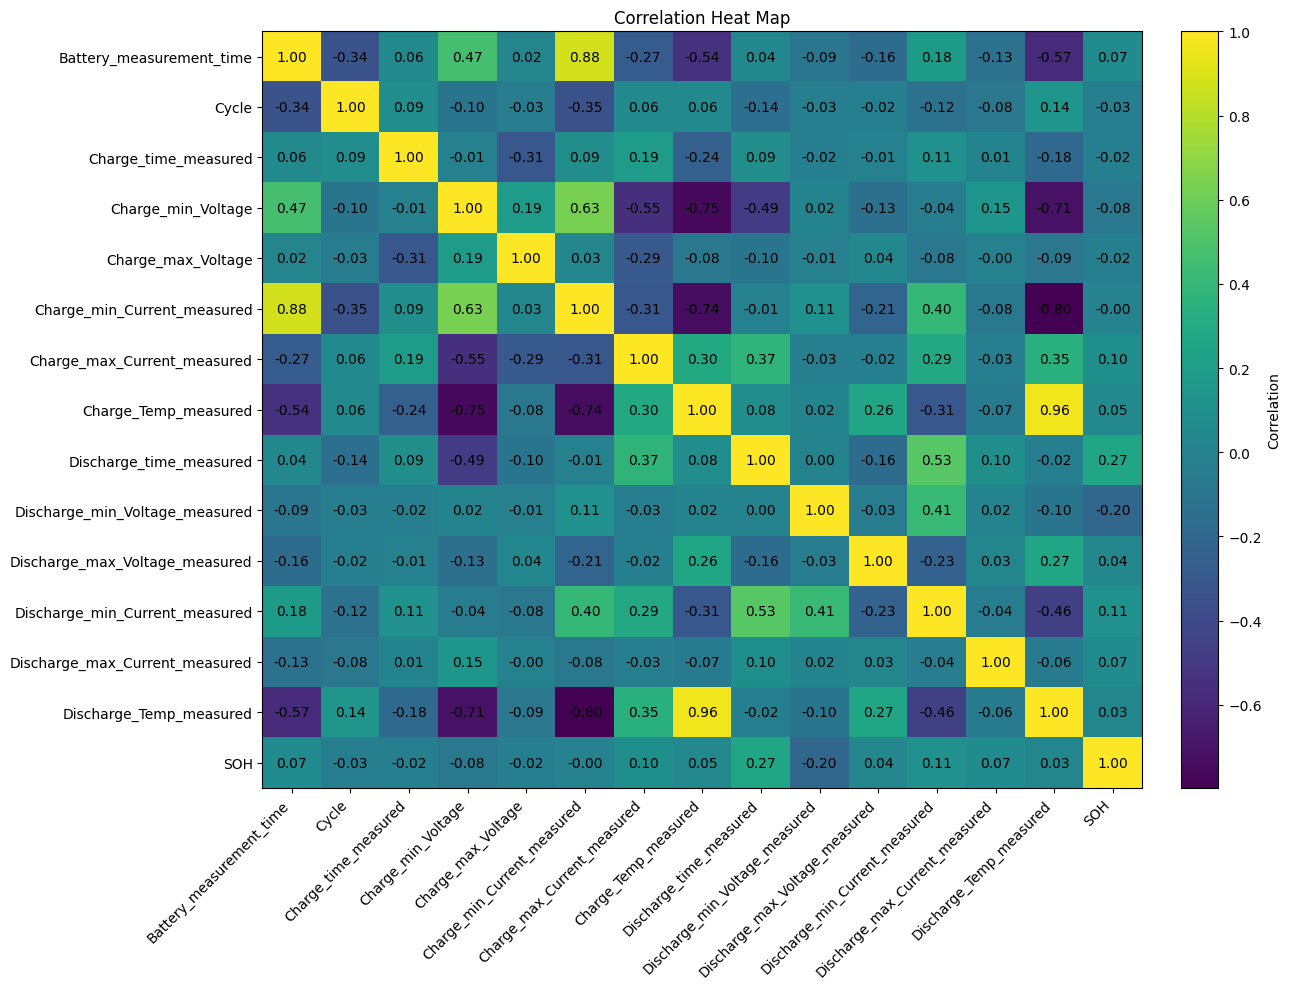

In [ ]:
data_ = data_original.drop(['Battery name','Unnamed: 0','Capacity'], axis = 1).dropna()

corr = data_.corr(numeric_only=True)
fig, ax = plt.subplots(figsize=(13, 10))
im = ax.imshow(corr.values, aspect='auto')
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.index)))
ax.set_xticklabels(corr.columns, rotation=45, ha='right')
ax.set_yticklabels(corr.index)
ax.set_title('Correlation Heat Map')

for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        ax.text(j, i, f"{corr.values[i, j]:.2f}", ha='center', va='center')

cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Correlation')
plt.tight_layout()
plt.show()

Post-optimisation correlation Heat map

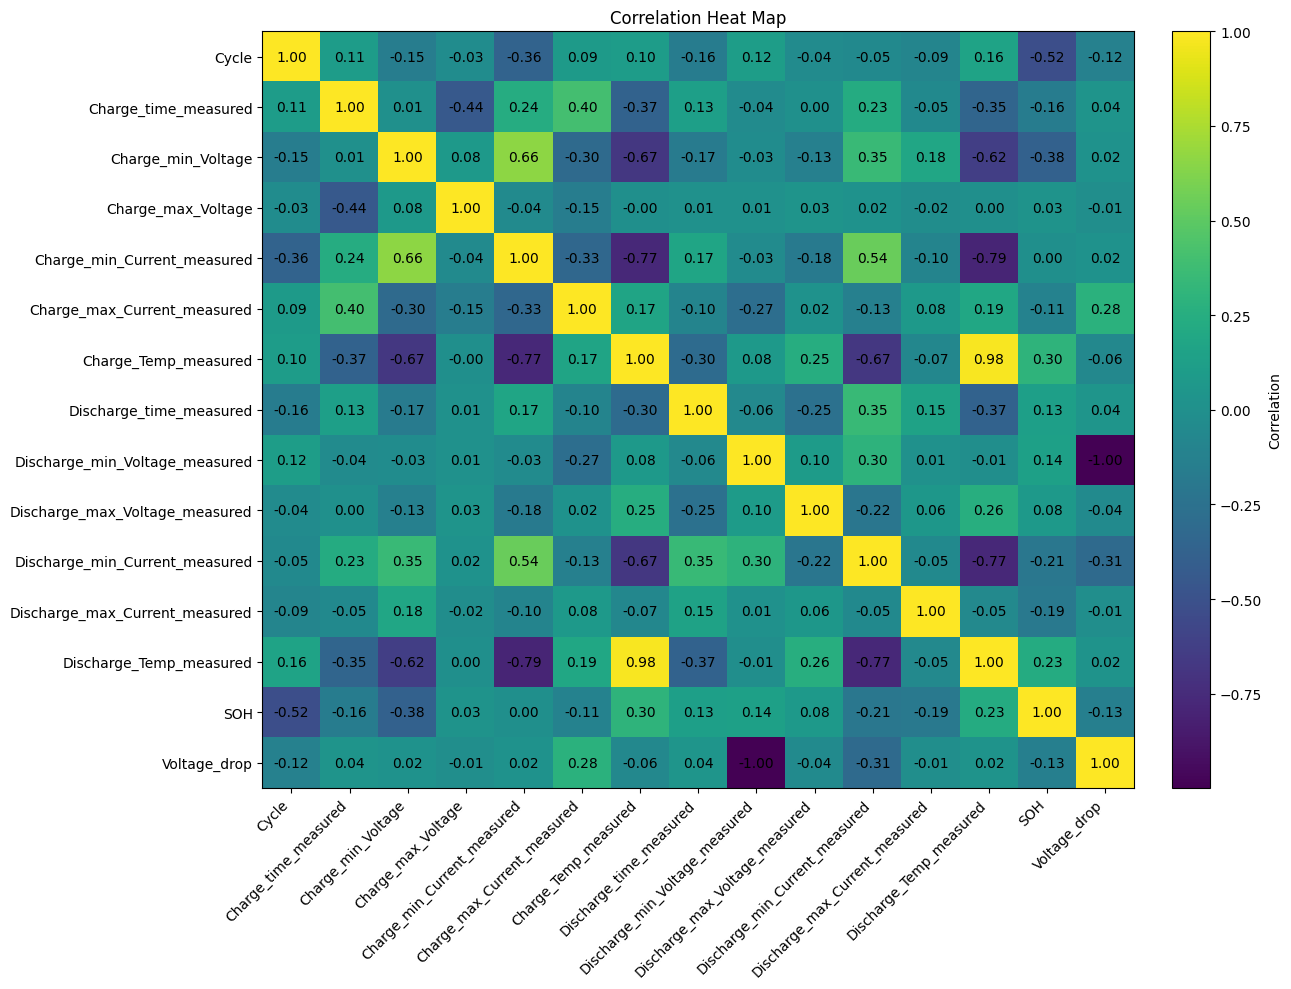

In [ ]:
corr = df.corr(numeric_only=True)
fig, ax = plt.subplots(figsize=(13, 10))
im = ax.imshow(corr.values, aspect='auto')
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.index)))
ax.set_xticklabels(corr.columns, rotation=45, ha='right')
ax.set_yticklabels(corr.index)
ax.set_title('Correlation Heat Map')

for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        ax.text(j, i, f"{corr.values[i, j]:.2f}", ha='center', va='center')

cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Correlation')
plt.tight_layout()
plt.show()

Get P values based on Shapiro-Wilk test.

In [ ]:
def Features_and_P_values_Shapiro_wilk_test(df,Target_Column):

  num_columns = df.select_dtypes(include=np.number).columns.tolist()
  Features_and_P_values = {}
  i = 0
  for c in num_columns:
    if c != Target_Column:
      value = [c,float(shapiro(df[c]).pvalue)]
      Features_and_P_values.update({i:value})
      i=i+1
  df_Features_and_P_values = pd.DataFrame()
  df_Features_and_P_values = pd.DataFrame.from_dict(Features_and_P_values, orient='index')
  df_Features_and_P_values.columns = ['Features','P-Value']
  return df_Features_and_P_values
Features_and_P_values_Shapiro_wilk_test(df,'SOH').to_excel("Features_and_P_values.xlsx")
Features_and_P_values_Shapiro_wilk_test(df,'SOH')

,Features,P-Value
0,Cycle,1.007827e-31
1,Charge_time_measured,1.534620e-62
2,Charge_min_Voltage,2.541073e-25
3,Charge_max_Voltage,2.679964e-71
4,Charge_min_Current_measured,1.482477e-46
5,Charge_max_Current_measured,1.148441e-61
6,Charge_Temp_measured,1.887214e-44
7,Discharge_time_measured,2.794621e-37
8,Discharge_min_Voltage_measured,1.958747e-33
9,Discharge_max_Voltage_measured,3.849819e-45


#Model Build

Dynamic functions will be used to build machine learning models. This will reduce time to train and test different models.

Train Test Split function

Sometims python built in train test split function gave errors. Builing seperate function was a work around.


In [ ]:
def train_test(X,Y,test_size_, random_state_):
  return train_test_split(X,Y, test_size=test_size_, random_state =random_state_)

#X_train, X_test, Y_train, Y_test = train_test(X,Y,test_size_,random_state_)

Build function to generate model evaluation metrics and place them into a dataframe.

In [ ]:
def Model_Evaluation_table(X_train,Y_train,X_test,Y_test,model):
  #Fit model on training and testing dataset
  model.fit(X_train, Y_train)
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  #Performance measures
  mae_test = round(mean_absolute_error(Y_test, y_test_pred),3)
  mae_train = round(mean_absolute_error(Y_train, y_train_pred),3)
  train_rmse = round(np.sqrt(mean_squared_error(Y_train, y_train_pred)),3)
  test_rmse  = round(np.sqrt(mean_squared_error(Y_test,  y_test_pred)),3)
  r2_train = round(r2_score(Y_train, y_train_pred),3)
  r2_test = round(r2_score(Y_test, y_test_pred),3)

  #Peformance Table
  Model_Evaluation_table = pd.DataFrame({
    'Model': [f"{model}",f"{model}"],
    'Features Used':[X_train.columns.tolist(),X_train.columns.tolist()],
    'Dataset': ['Training', 'Testing'],
    'RMSE':   [train_rmse, test_rmse],
    'MAE':    [mae_train, mae_test],
    'R2':     [r2_train, r2_test],
  })
  return Model_Evaluation_table

Build dynamic Backward Elimination function to generate best features based on input model.

In [ ]:
def Backward_Elimination(X,Y,model,test_size_,random_state_):
  X_train_initial, X_test_initial, Y_train_initial, Y_test_initial = train_test_split(X,Y, test_size=test_size_, random_state =random_state_)

  Back_Elimination = SequentialFeatureSelector(      model,
                                                     k_features= 'best',
                                                     forward=False,
                                                     floating=False,
                                                     verbose=2,
                                                     scoring='neg_mean_squared_error',
                                                     cv = 5).fit(X_train_initial,Y_train_initial)
  #Get best features
  selected_features = list(Back_Elimination.k_feature_names_)
  #Only select best features as X
  #print(selected_features)
  Updated_X = X.loc[:,selected_features]
  #Return new train test split datasets - based on selected features.
  return train_test_split(Updated_X,Y, test_size = test_size_, random_state =random_state_)

#model = LinearRegression()
#X_train, X_test, Y_train, Y_test = Backward_Elimination(X,Y,model,test_size_,random_state_)


Build hyperparameter tuning function.

In [ ]:
def Hyperparameter_tuning(param_grid,X_train,Y_train,model):
  grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='neg_mean_squared_error',
              )

  grid_search.fit(X_train, Y_train)

  best_model_after_hyperparameter_tuning = grid_search.best_estimator_
  print("Selected Hyperparameters:", grid_search.best_params_)
  return best_model_after_hyperparameter_tuning

Pre-Optimisation Vs Post-Optimisation Functions

Pre-Optimisation function, will simply run model with existing train test split datasets and call the model evaluation function. The pre-optimisation function will return a dataframe with the model performance metrics.

In [ ]:
def Pre_Optimisation_Model_Performance(X,Y,test_size_,random_state_,model):

  X_train, X_test, Y_train, Y_test = train_test(X,Y,test_size_,random_state_)

  df_Model_Evaluation_table = Model_Evaluation_table(X_train,Y_train,X_test,Y_test,model)

  return df_Model_Evaluation_table

The Post Optimisation function will first run backward elimination to generate the best features and return a new train test split dataset based on the best features.

 Next, it will implement hyperparameter tuning to determine the best model. Finally, it will call the model evaluation function to generate the final results and put them into a dataframe.

In [ ]:
def Post_Optimisation_Model_Performance(X,Y,model,test_size_,random_state_,param_grid):
  X_train, X_test, Y_train, Y_test = Backward_Elimination(X,Y,model,test_size_,random_state_)

  if param_grid != None:
    best_model_after_hyperparameter_tuning = Hyperparameter_tuning(param_grid,X_train,Y_train,model)
    print("Hyperparameter Tuning Complete")
    df_Model_Evaluation_table = Model_Evaluation_table(X_train,Y_train,X_test,Y_test,best_model_after_hyperparameter_tuning)

  else:
    df_Model_Evaluation_table = Model_Evaluation_table(X_train,Y_train,X_test,Y_test,model)

  return df_Model_Evaluation_table

Split the dataset into pre-optimisation (the original data with limited changes) and post-optimisation (the data after several changes, including outlier removal, battery removal, column removal, and new feature creation).

In [ ]:
#Pre-optimisation Dataset for model build
data = data_original.dropna()
Y_Pre_optimisation = data['SOH']
X_Pre_optimisation = data.drop(['SOH','Battery name','Unnamed: 0','Capacity'], axis = 1)

#Post-optimisation dataset for model build
Y_Post_optimisation = df['SOH']
X_Post_optimisation = df.drop(['SOH','Battery name','Discharge_max_Voltage_measured','Charge_max_Voltage','Charge_max_Current_measured'], axis = 1)

#Fixed Sample size and random state
test_size_ = 0.2
random_state_ = 25

Now we run all models into the Pre-Optimisation and Post-Optimisation functions.

##Linear Regression: Pre-Optimisation


In [ ]:
pd.set_option('display.max_colwidth', None) # Allows us to view all the features in the dataframe column
Y = Y_Pre_optimisation
X = X_Pre_optimisation
model = LinearRegression()

Pre_Optimisation_Model_Performance(X,Y,test_size_,random_state_,model)


,Model,Features Used,Dataset,RMSE,MAE,R2
0,LinearRegression(),"[Battery_measurement_time, Cycle, Charge_time_measured, Charge_min_Voltage, Charge_max_Voltage, Charge_min_Current_measured, Charge_max_Current_measured, Charge_Temp_measured, Discharge_time_measured, Discharge_min_Voltage_measured, Discharge_max_Voltage_measured, Discharge_min_Current_measured, Discharge_max_Current_measured, Discharge_Temp_measured]",Training,158.457,63.996,0.170
1,LinearRegression(),"[Battery_measurement_time, Cycle, Charge_time_measured, Charge_min_Voltage, Charge_max_Voltage, Charge_min_Current_measured, Charge_max_Current_measured, Charge_Temp_measured, Discharge_time_measured, Discharge_min_Voltage_measured, Discharge_max_Voltage_measured, Discharge_min_Current_measured, Discharge_max_Current_measured, Discharge_Temp_measured]",Testing,150.327,59.324,0.123


##Linear Regression: Post-Optimisation

In [ ]:
model = LinearRegression()
Y = Y_Post_optimisation
X = X_Post_optimisation
param_grid = None # No hyperparameters selected

Post_Optimisation_Model_Performance(X,Y,model,test_size_,random_state_,param_grid)

[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.1s finished

[2025-11-25 16:28:46] Features: 10/1 -- score: -34.57118964060295[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished

[2025-11-25 16:28:46] Features: 9/1 -- score: -34.568369622151806[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s finished

[2025-11-25 16:28:46] Features: 8/1 -- score: -34.62891236851222[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s finished

[2025-11-25 16:28:46] Features: 7/1 -- score: -34.75584243194652[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s finished

[2025-11-25 16:28:46] Features: 6/1 -- score: -35.92531188758256[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s finished

[2025-11-25 16:28:46] Features: 5/1 -- score: -37.40250595920442[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished

[2025-11-25 16:28:46] Features: 4/1 -- score: -42.94556836878193[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 

,Model,Features Used,Dataset,RMSE,MAE,R2
0,LinearRegression(),"[Cycle, Charge_time_measured, Charge_min_Voltage, Charge_min_Current_measured, Discharge_time_measured, Discharge_min_Voltage_measured, Discharge_min_Current_measured, Discharge_max_Current_measured, Voltage_drop]",Training,5.850,4.325,0.638
1,LinearRegression(),"[Cycle, Charge_time_measured, Charge_min_Voltage, Charge_min_Current_measured, Discharge_time_measured, Discharge_min_Voltage_measured, Discharge_min_Current_measured, Discharge_max_Current_measured, Voltage_drop]",Testing,6.262,4.381,0.571


##Decision Tree Regressor: Pre-Optimisation

In [ ]:
Y = Y_Pre_optimisation
X = X_Pre_optimisation

model = DecisionTreeRegressor(random_state = random_state_)
Pre_Optimisation_Model_Performance(X,Y,test_size_,random_state_,model)

,Model,Features Used,Dataset,RMSE,MAE,R2
0,DecisionTreeRegressor(random_state=25),"[Battery_measurement_time, Cycle, Charge_time_measured, Charge_min_Voltage, Charge_max_Voltage, Charge_min_Current_measured, Charge_max_Current_measured, Charge_Temp_measured, Discharge_time_measured, Discharge_min_Voltage_measured, Discharge_max_Voltage_measured, Discharge_min_Current_measured, Discharge_max_Current_measured, Discharge_Temp_measured]",Training,0.000,0.000,1.000
1,DecisionTreeRegressor(random_state=25),"[Battery_measurement_time, Cycle, Charge_time_measured, Charge_min_Voltage, Charge_max_Voltage, Charge_min_Current_measured, Charge_max_Current_measured, Charge_Temp_measured, Discharge_time_measured, Discharge_min_Voltage_measured, Discharge_max_Voltage_measured, Discharge_min_Current_measured, Discharge_max_Current_measured, Discharge_Temp_measured]",Testing,94.249,6.744,0.655


##Decision Tree Regressor: Post-Optimisation

In [ ]:
Y = Y_Post_optimisation
X = X_Post_optimisation

model = DecisionTreeRegressor(
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state = random_state_ # We keep the random state of the model the same to ensure that we get the same results and selected features when running the model through backward elimination.
)
param_grid = {
    'max_depth': [3,4,5,7,10],
    'criterion':['squared_error','absolute_error'],
    'min_samples_split': [3, 4, 5,8, 10, 20],
    'min_samples_leaf': [2,3, 4, 6,10],
    'max_features':["sqrt", "log2"]
    }

Post_Optimisation_Model_Performance(X,Y,model,test_size_,random_state_,param_grid)


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.8s finished

[2025-11-25 16:28:47] Features: 10/1 -- score: -9.210073480961638[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished

[2025-11-25 16:28:48] Features: 9/1 -- score: -8.383197403682043[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.5s finished

[2025-11-25 16:28:48] Features: 8/1 -- score: -7.551377648256593[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.4s finished

[2025-11-25 16:28:49] Features: 7/1 -- score: -7.219019263059788[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.3s finished

[2025-11-25 16:28:49] Features: 6/1 -- score: -7.888556899931901[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.2s finished

[2025-11-25 16:28:49] Features: 5/1 -- score: -6.497447629361813[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished

[2025-11-25 16:28:50] Features: 4/1 -- score: -7.341574726349734

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished

[2025-11-25 16:28:50] Features: 3/1 -- score: -14.172373934002788[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished

[2025-11-25 16:28:50] Features: 2/1 -- score: -26.41870209576992[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished

[2025-11-25 16:28:50] Features: 1/1 -- score: -56.133224261226914

Selected Hyperparameters: {'criterion': 'squared_error', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 3}
Hyperparameter Tuning Complete


,Model,Features Used,Dataset,RMSE,MAE,R2
0,"DecisionTreeRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=4,\n min_samples_split=3, random_state=25)","[Cycle, Charge_min_Current_measured, Discharge_time_measured, Discharge_min_Voltage_measured, Discharge_Temp_measured]",Training,1.894,1.060,0.962
1,"DecisionTreeRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=4,\n min_samples_split=3, random_state=25)","[Cycle, Charge_min_Current_measured, Discharge_time_measured, Discharge_min_Voltage_measured, Discharge_Temp_measured]",Testing,3.676,2.015,0.852


##SVR: Pre-Optimisation



In [ ]:
Y = Y_Pre_optimisation
X = X_Pre_optimisation

model = SVR()
Pre_Optimisation_Model_Performance(X,Y,test_size_,random_state_,model)

,Model,Features Used,Dataset,RMSE,MAE,R2
0,SVR(),"[Battery_measurement_time, Cycle, Charge_time_measured, Charge_min_Voltage, Charge_max_Voltage, Charge_min_Current_measured, Charge_max_Current_measured, Charge_Temp_measured, Discharge_time_measured, Discharge_min_Voltage_measured, Discharge_max_Voltage_measured, Discharge_min_Current_measured, Discharge_max_Current_measured, Discharge_Temp_measured]",Training,176.065,45.497,-0.024
1,SVR(),"[Battery_measurement_time, Cycle, Charge_time_measured, Charge_min_Voltage, Charge_max_Voltage, Charge_min_Current_measured, Charge_max_Current_measured, Charge_Temp_measured, Discharge_time_measured, Discharge_min_Voltage_measured, Discharge_max_Voltage_measured, Discharge_min_Current_measured, Discharge_max_Current_measured, Discharge_Temp_measured]",Testing,161.496,39.131,-0.013


##SVR: Post-Optimisation

For SVR we scale features using Z-score.

In [ ]:
Y = Y_Post_optimisation
X = X_Post_optimisation
#Apply z-score standardization
Scaled = StandardScaler()
Scaled_X = Scaled.fit_transform(X)
df_Scaled_X = pd.DataFrame(Scaled_X, columns=X.columns)

model = SVR()
param_grid = {
   'kernel':['rbf','sigmoid','poly'],
   #'C':[0.1,0.2,0.5,1]
   'C':[0.1,1,10,100],
   'epsilon': [0.1,1,10,100]
    }

#Backward_Elimination(df_Scaled_X,Y,model,test_size_,random_state_)
#We use scaled dataset (df_Scaled_X) in place of X.
Post_Optimisation_Model_Performance(df_Scaled_X,Y,model,test_size_,random_state_,param_grid)

[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    3.5s finished

[2025-11-25 16:29:28] Features: 10/1 -- score: -20.77050968247327[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.7s finished

[2025-11-25 16:29:32] Features: 9/1 -- score: -20.489344663063168[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.7s finished

[2025-11-25 16:29:35] Features: 8/1 -- score: -20.39087046893611[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.4s finished

[2025-11-25 16:29:37] Features: 7/1 -- score: -20.16827136591151[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.0s finished

[2025-11-25 16:29:39] Features: 6/1 -- score: -20.016055446781984[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.3s finished

[2025-11-25 16:29:41] Features: 5/1 -- score: -21.12359533865115[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s finished

[2025-11-25 16:29:43] Features: 4/1 -- score: -22.532664322404564[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Selected Hyperparameters: {'C': 100, 'epsilon': 1, 'kernel': 'rbf'}
Hyperparameter Tuning Complete


,Model,Features Used,Dataset,RMSE,MAE,R2
0,"SVR(C=100, epsilon=1)","[Cycle, Charge_min_Voltage, Charge_min_Current_measured, Discharge_time_measured, Discharge_min_Current_measured, Voltage_drop]",Training,2.852,1.398,0.914
1,"SVR(C=100, epsilon=1)","[Cycle, Charge_min_Voltage, Charge_min_Current_measured, Discharge_time_measured, Discharge_min_Current_measured, Voltage_drop]",Testing,3.504,1.698,0.866
